### 情感分析与预测
#### 郑宇浩 41621101
#### 该文件主要对应于论文中的注释[12]，实现2014年3月3日至2016年2月29日带关键词“股票市场”的所有微博情感周得分与沪深300指数周收盘价的趋势相关性分析、情感得分增量对股价涨跌幅的预测分析以及日内股民情感变化分析

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
path=os.path.abspath('.')

#### 1. 数据导入与处理：文件位于与该notebook同目录下的文件夹，文件名为股票市场.xlsx、股票代码.xlsx、股票交易.xlsx

In [2]:
df=pd.read_excel(path+"\股票市场.xlsx")
# 导入的DataFrame结构为{日期，时间段，一个时间段内的所有评论，一个时间段内的所有评分}

def str2int(List):
    if(List=='[]'):
        List=[np.nan] # 若当天的某一时间段没有评论，则设置为缺失值便于后续处理
    else:
        List=List[1:-1].split(", ")
        List=[float(i) for i in List]
    return List
df.score=df.score.apply(str2int)

def Count(List):
    if(np.nan in List):
        count=0
    else:
        count=len(List)
    return count

# 分别求算每一个时间段的情感评分均值、总得分与评论数

df["ave_score"]=df["score"].apply(lambda x: np.mean(x))
df["sum_score"]=df["score"].apply(lambda x: sum(x))
df["num_comments"]=df["score"].apply(Count)

# 按天分类即可得到每一天的情感评分均值、总得分与评论数

gb_daily=df.groupby("Day")
daily=pd.DataFrame({"Sum":gb_daily["sum_score"].sum(),"Num":gb_daily["num_comments"].sum()})
daily["Ave"]=daily["Sum"]/daily["Num"]

# 再按周进行整合，以便后期与沪深300指数的周收盘价画图作对比

weekly_ave,weekly_sum,weekly_num=[],[],[]
weekly_ave.append(np.mean(daily["Ave"].iloc[:5]))
weekly_sum.append(sum(daily["Sum"].iloc[:5]))
weekly_num.append(sum(daily["Num"].iloc[:5]))
n=len(daily["Ave"].iloc[:-3])
for i in range(5,n-7,7):
    weekly_ave.append(np.mean(daily["Ave"][i:i+7]))
    weekly_sum.append(sum(daily["Sum"][i:i+7]))
    weekly_num.append(sum(daily["Num"][i:i+7]))
weekly=pd.DataFrame({"Sum":weekly_sum,"Num":weekly_num,"Ave":weekly_ave})

# 按时间段分类可研究一天内股民们的情感波动情况

gb_inday=df.groupby("Hour")
inday=pd.DataFrame({"Sum":gb_inday["sum_score"].sum(),"Num":gb_inday["num_comments"].sum()})
inday["Ave"]=inday["Sum"]/inday["Num"]

#### 2. 情感趋势分析

([<matplotlib.axis.XTick at 0x1af8353e1d0>,
 <a list of 4 Text xticklabel objects>)

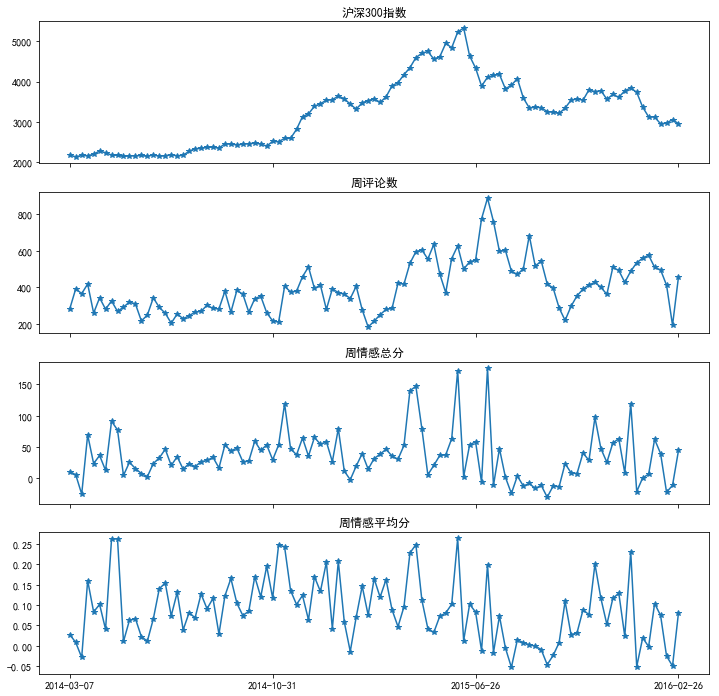

In [3]:
stock_300=list(reversed(list(ts.get_hist_data("hs300",'2014-03-03','2016-02-29','W')['close'])))
date=list(reversed(list(ts.get_hist_data("hs300",'2014-03-03','2016-02-29','W')['close'].index)))

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig,(ax,ax0,ax1,ax2)=plt.subplots(4,1,sharex=True,figsize=(12,12))
ax.plot(stock_300,'*-')
ax.set_title('沪深300指数')
ax0.plot(weekly["Num"],'*-')
ax0.set_title('周评论数')
ax1.plot(weekly["Sum"],'*-')
ax1.set_title('周情感总分')
ax2.plot(weekly["Ave"],'*-')
ax2.set_title('周情感平均分')
plt.xticks([weekly.index[0],weekly.index[34],weekly.index[68],weekly.index[102]],
            [date[0],date[34],date[68],date[102]])

#### 3. 情感变化分析

In [4]:
# 对周情感得分进行增量的求算，与沪深300指数周收盘价涨跌幅进行对比

weekly["Norm_Num"]=(weekly["Num"]-np.mean(weekly["Num"]))/np.std(weekly["Num"])
weekly["Norm_Sum"]=(weekly["Sum"]-np.mean(weekly["Sum"]))/np.std(weekly["Sum"])
weekly["Norm_Ave"]=(weekly["Ave"]-np.mean(weekly["Ave"]))/np.std(weekly["Ave"])
weekly["Stock"]=stock_300
weekly["Norm_Stock"]=(weekly["Stock"]-np.mean(weekly["Stock"]))/np.std(weekly["Stock"])
increase_num,increase_sum,increase_ave,increase_stock=[],[],[],[]
increase_num.append(0)
increase_sum.append(0)
increase_ave.append(0)
increase_stock.append(0)
n=len(stock_300)
for i in range(1,n,1):
    increase_num.append(weekly["Norm_Num"].iloc[i]-weekly["Norm_Num"].iloc[i-1])
    increase_sum.append(weekly["Norm_Sum"].iloc[i]-weekly["Norm_Sum"].iloc[i-1])
    increase_ave.append(weekly["Norm_Ave"].iloc[i]-weekly["Norm_Ave"].iloc[i-1])
    increase_stock.append((weekly["Norm_Stock"].iloc[i]-weekly["Norm_Stock"].iloc[i-1])*10)
weekly["increase_Num"]=increase_sum
weekly["increase_Sum"]=increase_num
weekly["increase_Ave"]=increase_ave
weekly["increase_Stock"]=increase_stock

([<matplotlib.axis.XTick at 0x1af83b07e48>,
 <a list of 4 Text xticklabel objects>)

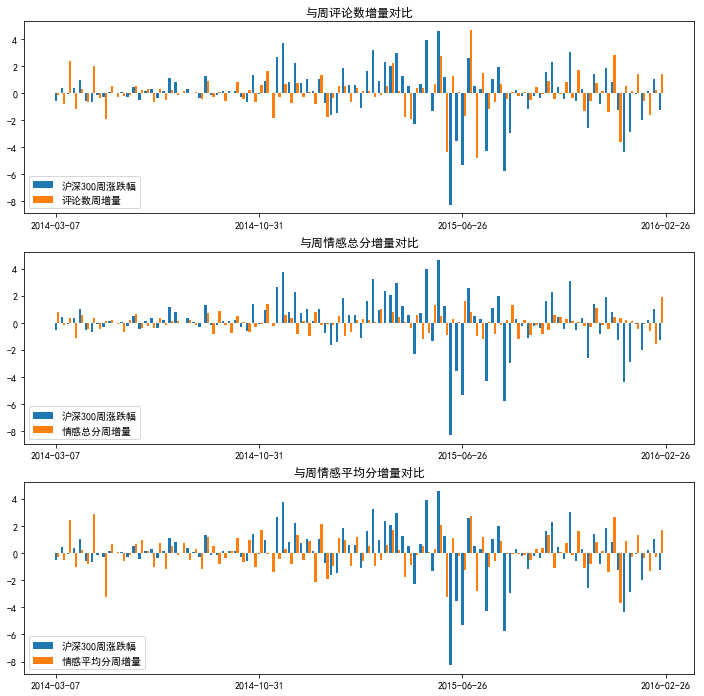

In [5]:
# 作图分析

n=len(date[1:])
index=np.arange(0,n,1)
width=0.4
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.bar(index,weekly.increase_Stock[1:],width,label="沪深300周涨跌幅")
plt.bar(index+width,weekly.increase_Num[1:],width,label="评论数周增量")
plt.legend(bbox_to_anchor=(0,0),loc=3)
plt.title('与周评论数增量对比')
plt.xticks([weekly.index[0],weekly.index[34],weekly.index[68],weekly.index[102]],
            [date[0],date[34],date[68],date[102]])
plt.subplot(3,1,2)
plt.bar(index,weekly.increase_Stock[1:],width,label="沪深300周涨跌幅")
plt.bar(index+width,weekly.increase_Sum[1:],width,label="情感总分周增量")
plt.legend(bbox_to_anchor=(0,0),loc=3)
plt.title('与周情感总分增量对比')
plt.xticks([weekly.index[0],weekly.index[34],weekly.index[68],weekly.index[102]],
            [date[0],date[34],date[68],date[102]])
plt.subplot(3,1,3)
plt.bar(index,weekly.increase_Stock[1:],width,label="沪深300周涨跌幅")
plt.bar(index+width,weekly.increase_Ave[1:],width,label="情感平均分周增量")
plt.legend(bbox_to_anchor=(0,0),loc=3)
plt.title('与周情感平均分增量对比')
plt.xticks([weekly.index[0],weekly.index[34],weekly.index[68],weekly.index[102]],
            [date[0],date[34],date[68],date[102]])

In [6]:
# 同样生成时差相关系数，算法请参考论文中的公式(1)

ahead_corr={}
items=["Num","Sum","Ave"]
for i in items:
    corr=0
    ahead=0
    for j in range(1,5,1):
        matrix=np.array([stock_300[j:],weekly[i].iloc[:-j]])
        if(abs(np.corrcoef(matrix)[0,1])>abs(corr)):
            corr=np.corrcoef(matrix)[0,1]
            ahead=j
    ahead_corr[i]=[corr,ahead]
sort=sorted(ahead_corr.items(),key=lambda x:x[1],reverse=True)
new_ahead_corr={}
n=len(items)
for i in range(n):
    new_ahead_corr[sort[i][0]]=sort[i][1]

In [7]:
new_ahead_corr

{'Num': [0.6160709834713034, 1],
 'Sum': [0.24708211665551175, 1],
 'Ave': [0.01911256906651718, 4]}

#### 4. 情感预测：算法请参考论文中的公式(6)

In [8]:
num_accuracy,sum_accuracy,ave_accuracy=[],[],[]
n=len(date[1:])
for i in range(n):
    if weekly["increase_Num"].iloc[i]*weekly["increase_Stock"][i+1]>=0:
        num_accuracy.append(1)
    else:
        num_accuracy.append(0)
    if weekly["increase_Sum"].iloc[i]*weekly["increase_Stock"][i+1]>=0:
        sum_accuracy.append(1)
    else:
        sum_accuracy.append(0)
    if weekly["increase_Ave"].iloc[i]*weekly["increase_Stock"][i+1]>=0:
        ave_accuracy.append(1)
    else:
        ave_accuracy.append(0)
print("三个微博情感指标对股市变化的预测精确度分别为："+
      str(np.mean(num_accuracy))+","+str(np.mean(sum_accuracy))+","+str(np.mean(ave_accuracy)))

三个微博情感指标对股市变化的预测精确度分别为：0.5196078431372549,0.5686274509803921,0.49019607843137253


#### 5. 日内情感变化分析

Text(0.5,1,'日内情感平均分')

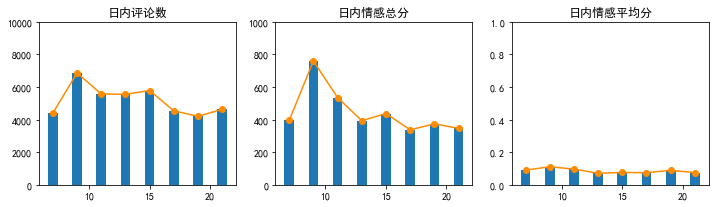

In [9]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.bar(inday.index,inday.Num)
plt.plot(inday.index,inday.Num,"-o",color="#FF8C00")
plt.ylim(0,10000)
plt.title('日内评论数')
plt.subplot(1,3,2)
plt.bar(inday.index,inday.Sum)
plt.plot(inday.index,inday.Sum,"-o",color="#FF8C00")
plt.ylim(0,1000)
plt.title('日内情感总分')
plt.subplot(1,3,3)
plt.bar(inday.index,inday.Ave)
plt.plot(inday.index,inday.Ave,"-o",color="#FF8C00")
plt.ylim(0,1)
plt.title('日内情感平均分')